In [1]:
import numpy as np
import pandas as pd
# df = pd.read_csv('test_reliability_0z_href_only.csv')
df = pd.read_csv('stats_0z_href_only.csv')
# df["spc_success_ratio"] = df["spc_success_ratio"].astype(float)
# df["spc_pod"]           = df["spc_pod"].astype(float)
import matplotlib

def sheet(df):
    import dtale
    return dtale.show(df)


In [2]:
# tor_df = df[df["event"] == "tornado"].copy()
# tor_df["spc_success_ratio"] = tor_df["spc_success_ratio"].astype(float)
# tor_df["spc_pod"]           = tor_df["spc_pod"].astype(float)
# tor_df

In [3]:
# sig_tor_df = df[df["event"] == "sig_tornado_gated_by_tornado"].copy()
# sig_tor_df = sig_tor_df[sig_tor_df["threshold"] == 0.1].copy()
# sig_tor_df.index = range(len(sig_tor_df))
# sig_tor_df["spc_success_ratio"] = sig_tor_df["spc_success_ratio"].astype(float)
# sig_tor_df["spc_pod"]           = sig_tor_df["spc_pod"].astype(float)
# sig_tor_df

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

In [5]:
tornado_colors = [
    (0.0,  (1.,1.,1.))
  , (0.01, (0.570,0.570,0.570))
  , (0.02, (0.067,0.541,0.078))
  , (0.05, (0.541,0.278,0.165))
  , (0.1,  (0.996,0.780,0.180))
  , (0.15, (0.988,0.051,0.106))
  , (0.30, (0.988,0.157,0.988))
  , (0.45, (0.565,0.224,0.918))
  , (0.60, (0.082,0.310,0.537))
  ]

wind_hail_colors = [
    (0.0,  (1.,1.,1.))
  , (0.02, (0.570,0.570,0.570))
  , (0.05, (0.541,0.278,0.165))
  , (0.15, (0.996,0.780,0.180))
  , (0.30, (0.988,0.051,0.106))
  , (0.45, (0.988,0.157,0.988))
  , (0.60, (0.565,0.224,0.918))
  ]

sig_colors = [
    (0.0,  (1.,1.,1.))
  , (0.1,  (0.3,0.3,0.3))
  ]

# Regular tornado colors, but dark gray 10%
sig_tornado_more_colors = [
    (0.0,  (1.,1.,1.))
  , (0.01, (0.570,0.570,0.570))
  , (0.02, (0.067,0.541,0.078))
  , (0.05, (0.541,0.278,0.165))
  , (0.1,  (0.3,0.3,0.3))
  , (0.15, (0.988,0.051,0.106))
  , (0.30, (0.988,0.157,0.988))
  , (0.45, (0.565,0.224,0.918))
  , (0.60, (0.082,0.310,0.537))
  ]

# Regular wind and hail colors, but additional dark gray 10%
sig_wind_hail_more_colors = [
    (0.0,  (1.,1.,1.))
  , (0.02, (0.570,0.570,0.570))
  , (0.05, (0.541,0.278,0.165))
  , (0.1,  (0.3,0.3,0.3))
  , (0.15, (0.996,0.780,0.180))
  , (0.30, (0.988,0.051,0.106))
  , (0.45, (0.988,0.157,0.988))
  , (0.60, (0.565,0.224,0.918))
  ]

def lookup(key, pairs):
    return dict(pairs)[key]

In [6]:
def p_value(p):
    if p < .001: return "p<.001"
    if p < .01:  return f"p={p:.3f}".replace("0.", ".")
    return f"p={p:.2f}".replace("0.", ".")

p_value(0.5)

'p=.50'

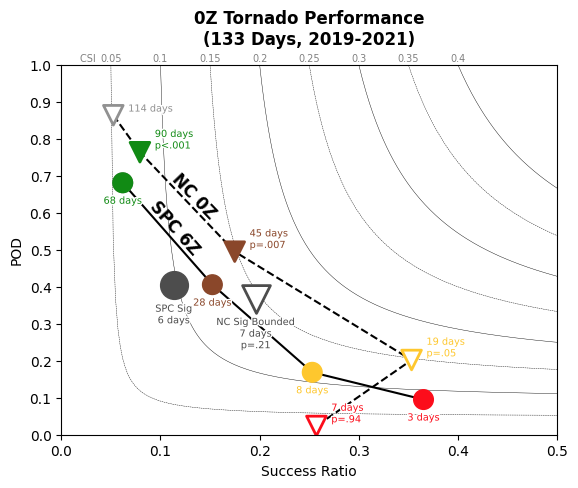

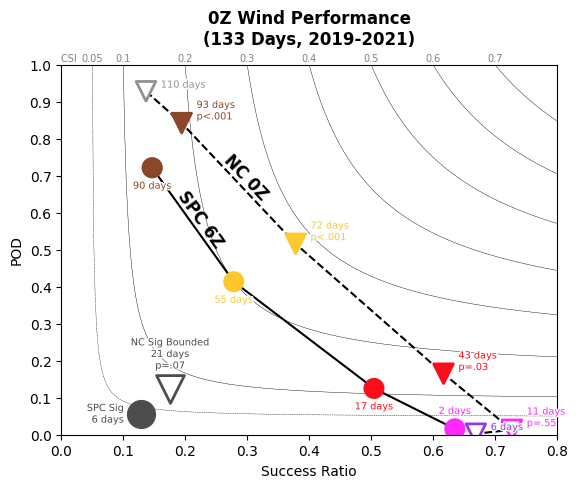

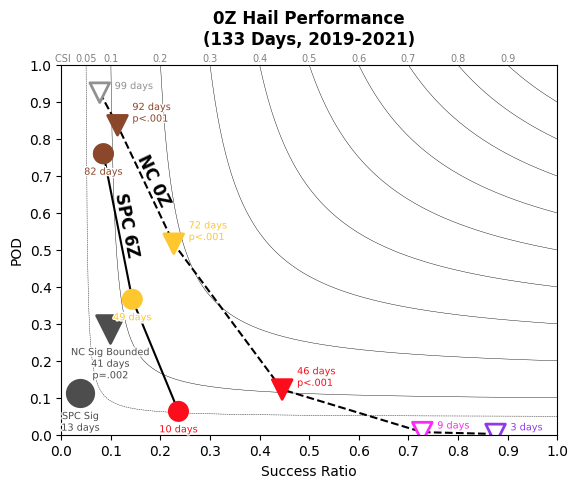

In [7]:
def perf_plot(csv_path, nc_label, spc_label, nice_event, event, sig_event, event_colors, sig_event_colors, xmax, extra_csi_thresholds, nc_sig_label_position=None):
    full_df = pd.read_csv(csv_path)

    df = full_df[full_df["event"] == event].copy()
    df.index = range(len(df))
    df["spc_success_ratio"] = df["spc_success_ratio"].astype(float)
    df["spc_pod"]           = df["spc_pod"].astype(float)

    sig_df = full_df[full_df["event"] == sig_event].copy()
    sig_df = sig_df[sig_df["threshold"] == 0.1].copy()
    sig_df.index = range(len(sig_df))
    sig_df["spc_success_ratio"] = sig_df["spc_success_ratio"].astype(float)
    sig_df["spc_pod"]           = sig_df["spc_pod"].astype(float)
    
    event_colors     = [lookup(threshold, event_colors)     for threshold in df["threshold"]]
    sig_event_colors = [lookup(threshold, sig_event_colors) for threshold in sig_df["threshold"]]

    fig, ax = plt.subplots()

    ax.set_xlim(0,.4)
    ax.set_ylim(0,1)
    ax.set_xticks(np.arange(0.,xmax + .01,0.1))
    ax.set_yticks(np.arange(0.,1.01,0.1))
    ax.set_xlabel("Success Ratio")
    ax.set_ylabel("POD")

    xmax = ax.get_xlim()[1]
    ymax = ax.get_ylim()[1]

    ax.set_title(f"{nice_event} Performance\n({df['days_count'][0]} Days, 2019-2021)", pad=15, fontdict={"fontweight":"bold"})
    # ax.set_aspect(1)

    # SPC
    ax.plot("spc_success_ratio", "spc_pod", zorder=-1, c=(0,0,0), linewidth=1.5, data=df)
    ax.scatter("spc_success_ratio", "spc_pod", s=200, marker="o", c=event_colors, data=df)

    # NC
    nc_xs = df["nadocast_success_ratio"][df["nadocast_threshold_days"] >= 2]
    nc_ys = df["nadocast_pod"][df["nadocast_threshold_days"] >= 2]
    ax.plot(nc_xs, nc_ys, zorder=-1, c=(0,0,0), linewidth=1.5, linestyle="--")
    nadocast_fills = [event_colors[i] if df["p_value_nadocast_csi_better"][i] < 0.05 and (i+1 == len(df) or df["spc_pod"][i] != df["spc_pod"][i+1]) and df["spc_threshold_days"][i] >= 1 else (1,1,1) for i in df["threshold"][df["nadocast_threshold_days"] >= 2].index]
    ax.scatter(nc_xs, nc_ys, s=200, marker="v", color=nadocast_fills, edgecolors=event_colors, linewidths=2)

    # SPC Sig
    ax.scatter("spc_success_ratio", "spc_pod", s=400, marker="o", c=sig_event_colors, data=sig_df)

    # NC Sig
    nadocast_fills = [sig_event_colors[i] if sig_df["p_value_nadocast_csi_better"][i] < 0.05 else (1,1,1) for i in range(len(sig_df["threshold"]))]
    ax.scatter("nadocast_success_ratio", "nadocast_pod", s=400, marker="v", color=nadocast_fills, edgecolors=sig_event_colors, linewidths=2, data=sig_df)

    # Series labels
    x1, y1 = ax.transData.transform((df["nadocast_success_ratio"][1], df["nadocast_pod"][1]))
    x2, y2 = ax.transData.transform((df["nadocast_success_ratio"][2], df["nadocast_pod"][2]))
    nc_legend_rot = np.degrees(np.arctan2(y2 - y1, x2 - x1))
    ax.text(0.5*df["nadocast_success_ratio"][1] + 0.5*df["nadocast_success_ratio"][2], 0.5*df["nadocast_pod"][1] + 0.5*df["nadocast_pod"][2], nc_label,  fontsize=12, horizontalalignment="center", va="bottom", fontweight="bold", rotation=nc_legend_rot, rotation_mode="anchor", linespacing=0.9)
#     ax.text(df["nadocast_success_ratio"][0] - 0.035*xmax*np.cos(np.radians(legend_rot)), df["nadocast_pod"][0] - 0.035*ymax*np.sin(np.radians(legend_rot)), f"NC 0Z",  fontsize=12, horizontalalignment="right", va="center", fontweight="bold", rotation=legend_rot, rotation_mode="anchor")
    x1, y1 = ax.transData.transform((df["spc_success_ratio"][1], df["spc_pod"][1]))
    x2, y2 = ax.transData.transform((df["spc_success_ratio"][2], df["spc_pod"][2]))
    spc_legend_rot = np.degrees(np.arctan2(y2 - y1, x2 - x1))
    if (x1, y1) != (x2, y2):
        ax.text(0.5*df["spc_success_ratio"][1] + 0.5*df["spc_success_ratio"][2], 0.5*df["spc_pod"][1] + 0.5*df["spc_pod"][2], spc_label, fontsize=12, horizontalalignment="center", va="bottom", fontweight="bold", rotation=spc_legend_rot, rotation_mode="anchor", linespacing=0.9)
    else:
        ax.text(df["spc_success_ratio"][1] - 0.03*xmax, df["spc_pod"][1], spc_label, fontsize=12, horizontalalignment="right", va="center", fontweight="bold", linespacing=0.9)
#     ax.text(df["spc_success_ratio"][0]      - 0.035*xmax*np.cos(np.radians(legend_rot)), df["spc_pod"][0]      - 0.035*ymax*np.sin(np.radians(legend_rot)), f"SPC 0Z", fontsize=12, horizontalalignment="right", va="center", fontweight="bold", rotation=legend_rot, rotation_mode="anchor")

    white_outline = [pe.withStroke(linewidth=2, foreground=(1,1,1))]

    # NC symbol labels
    for i in range(len(df["threshold"])):
        ndays = df["nadocast_threshold_days"][i]
        x = df["nadocast_success_ratio"][i]
        y = df["nadocast_pod"][i]
        if ndays <= 1: continue
        if np.isnan(x): continue
        if np.isnan(y): continue
        p = df["p_value_nadocast_csi_better"][i]
        p_str = f"\n{p_value(p)}" if (i+1 == len(df) or df["spc_pod"][i] != df["spc_pod"][i+1]) and df["spc_threshold_days"][i] >= 1 else ""
        if x < 0.92*xmax:
            ax.text(x + 0.03*xmax, y + 0.01*ymax, f"{ndays} days{p_str}", fontsize=7, horizontalalignment="left", c=event_colors[i], path_effects=white_outline)
        else:
            ax.text(x - 0.03*xmax, y + 0.01*ymax, f"{ndays} days{p_str}", fontsize=7, horizontalalignment="right", c=event_colors[i], path_effects=white_outline)

    # SPC symbol labels
    for i in range(len(df["threshold"])):
        ndays = df["spc_threshold_days"][i]
        x = df["spc_success_ratio"][i]
        y = df["spc_pod"][i]
#         if int(ndays) <= 2: continue
        if np.isnan(x): continue
        if np.isnan(y): continue
        if y > 0.05*ymax:
            ax.text(x, y - 0.035*ymax, f"{ndays} days", fontsize=7, horizontalalignment="center", va="top", c=event_colors[i], path_effects=white_outline)
        else:
            ax.text(x, y + 0.035*ymax, f"{ndays} days", fontsize=7, horizontalalignment="center", va="bottom", c=event_colors[i], path_effects=white_outline)

    # NC sig symbol labels
    for i in range(len(sig_df["threshold"])):
        ndays = sig_df["nadocast_threshold_days"][i]
        x = sig_df["nadocast_success_ratio"][i]
        y = sig_df["nadocast_pod"][i]
        if np.isnan(x): continue
        if np.isnan(y): continue
        p = sig_df["p_value_nadocast_csi_better"][i]
        if nc_sig_label_position == "right":
            ax.text(x + 0.04*xmax, y, f"NC Sig Bounded\n{ndays} days\n{p_value(p)}", fontsize=7, horizontalalignment="left", va="center", c=sig_event_colors[i], path_effects=white_outline)
        elif y > 0.15*ymax:
            ax.text(x, y - 0.05*ymax, f"NC Sig Bounded\n{ndays} days\n{p_value(p)}", fontsize=7, horizontalalignment="center", va="top", c=sig_event_colors[i], path_effects=white_outline)
        else:
            ax.text(x, y + 0.05*ymax, f"NC Sig Bounded\n{ndays} days\n{p_value(p)}", fontsize=7, horizontalalignment="center", va="bottom", c=sig_event_colors[i], path_effects=white_outline)


    # SPC sig symbol labels
    for i in range(len(sig_df["threshold"])):
        ndays = sig_df["spc_threshold_days"][i]
        x = sig_df["spc_success_ratio"][i]
        y = sig_df["spc_pod"][i]
        if np.isnan(x): continue
        if np.isnan(y): continue
        if y > 0.07*ymax:
            ax.text(x, y - 0.05*ymax, f"SPC Sig\n{ndays} days", fontsize=7, horizontalalignment="center", va="top", c=sig_event_colors[i], path_effects=white_outline)
        else:
            ax.text(x - 0.035*xmax, y, f"SPC Sig\n{ndays} days", fontsize=7, horizontalalignment="right", va="center", c=sig_event_colors[i], path_effects=white_outline)


    # CSI 0.1 0.2 0.3 etc lines
    # cribbed from verif package
    ax.text(0.05, 1.01, "CSI     ", fontsize=7, horizontalalignment="right", c=(.5,.5,.5))
    threats = np.around(np.arange(0.1,xmax-.01,0.1), 1)
    for i in range(len(threats)):
        threat = threats[i]
        x = np.linspace(threat, 1, 400)
        label = ""
        if i == 0:
            label = "Threat score"
        y = 1.0 / (1 + 1.0/threat - 1.0 / x)
        ax.plot(x, y, 'k-', zorder=-1, linewidth=0.3, label=label)
        ax.text(threat, 1.01, str(threat), fontsize=7, horizontalalignment="center", c=(.5,.5,.5))

    # CSI 0.05 0.15 0.25 etc lines
    threats = extra_csi_thresholds
    for i in range(len(threats)):
        threat = threats[i]
        x = np.linspace(threat, 1, 400)
        y = 1.0 / (1 + 1.0/threat - 1.0 / x)
        ax.plot(x, y, 'k--', zorder=-1, linewidth=0.3)
        ax.text(threat, 1.01, str(threat), fontsize=7, horizontalalignment="center", c=(.5,.5,.5))

    plt.show()


perf_plot("stats_0z_href_only.csv", "NC 0Z", "SPC 6Z", "0Z Tornado", "tornado", "sig_tornado_gated_by_tornado", tornado_colors, sig_tornado_more_colors, 0.5, [0.05, 0.15, 0.25, 0.35])
perf_plot("stats_0z_href_only.csv", "NC 0Z", "SPC 6Z", "0Z Wind", "wind", "sig_wind_gated_by_wind", wind_hail_colors, sig_wind_hail_more_colors, 0.8, [0.05])
perf_plot("stats_0z_href_only.csv", "NC 0Z", "SPC 6Z", "0Z Hail", "hail", "sig_hail_gated_by_hail", wind_hail_colors, sig_wind_hail_more_colors, 1, [0.05])

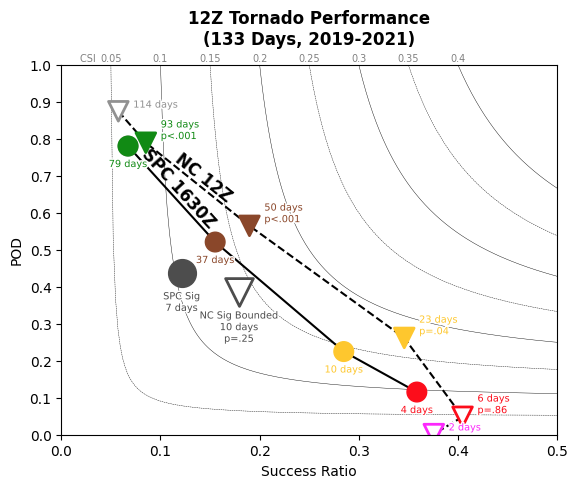

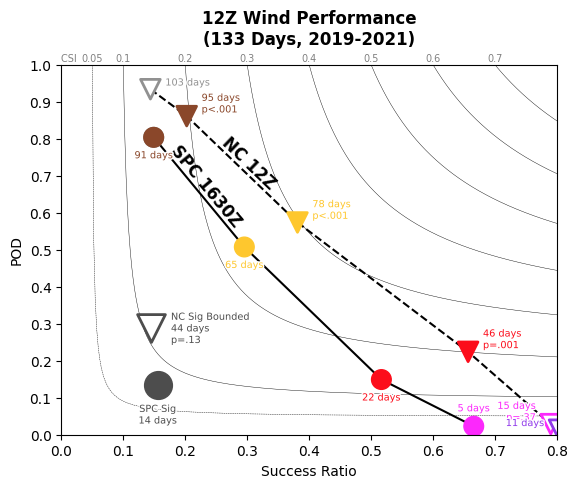

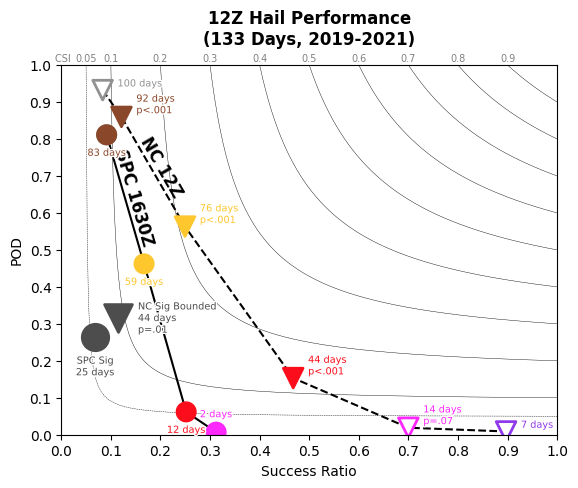

In [8]:
perf_plot("stats_12z_href_only.csv", "NC 12Z", "SPC 1630Z", "12Z Tornado", "tornado", "sig_tornado_gated_by_tornado", tornado_colors, sig_tornado_more_colors, 0.5, [0.05, 0.15, 0.25, 0.35])
perf_plot("stats_12z_href_only.csv", "NC 12Z", "SPC 1630Z", "12Z Wind", "wind", "sig_wind_gated_by_wind", wind_hail_colors, sig_wind_hail_more_colors, 0.8, [0.05], nc_sig_label_position="right")
perf_plot("stats_12z_href_only.csv", "NC 12Z", "SPC 1630Z", "12Z Hail", "hail", "sig_hail_gated_by_hail", wind_hail_colors, sig_wind_hail_more_colors, 1, [0.05], nc_sig_label_position="right")

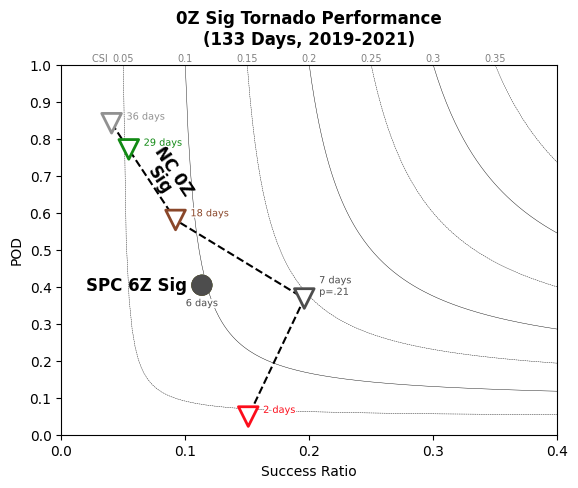

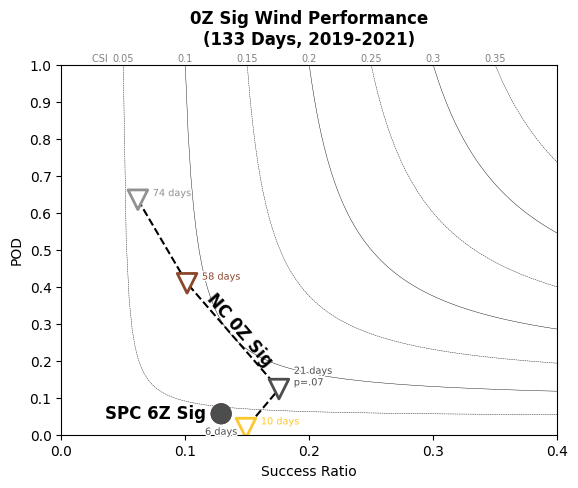

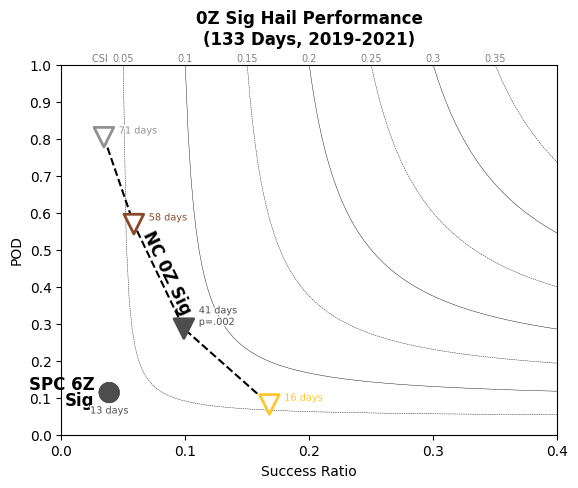

In [57]:
perf_plot("stats_0z_href_only.csv", "NC 0Z\nSig", "SPC 6Z Sig", "0Z Sig Tornado", "sig_tornado_gated_by_tornado", None, sig_tornado_more_colors, [], 0.4, [0.05, 0.15, 0.25, 0.35])
perf_plot("stats_0z_href_only.csv", "NC 0Z Sig", "SPC 6Z Sig", "0Z Sig Wind", "sig_wind_gated_by_wind", None, sig_wind_hail_more_colors, [], 0.4, [0.05, 0.15, 0.25, 0.35])
perf_plot("stats_0z_href_only.csv", "NC 0Z Sig", "SPC 6Z\nSig", "0Z Sig Hail", "sig_hail_gated_by_hail", None, sig_wind_hail_more_colors, [], 0.4, [0.05, 0.15, 0.25, 0.35])

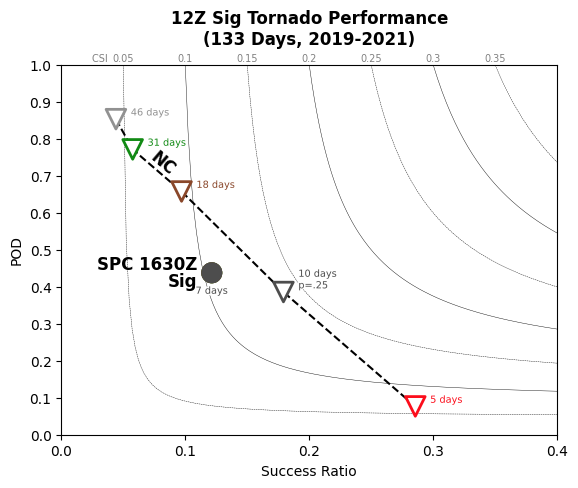

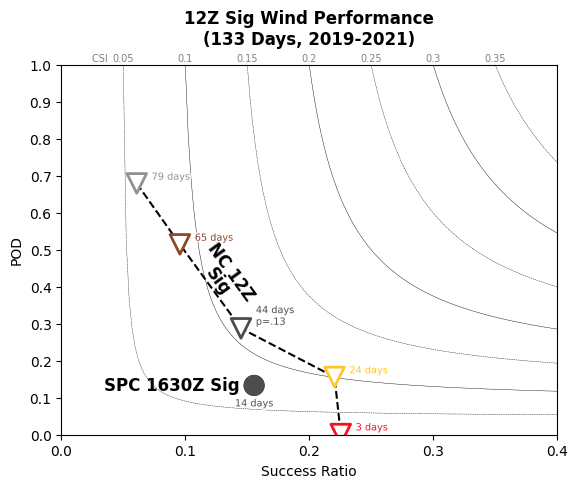

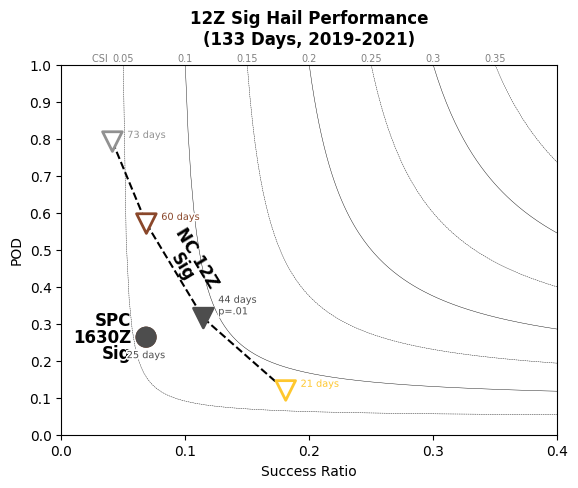

In [58]:
perf_plot("stats_12z_href_only.csv", "NC", "SPC 1630Z\nSig", "12Z Sig Tornado", "sig_tornado_gated_by_tornado", None, sig_tornado_more_colors, [], 0.4, [0.05, 0.15, 0.25, 0.35])
perf_plot("stats_12z_href_only.csv", "NC 12Z\nSig", "SPC 1630Z Sig", "12Z Sig Wind", "sig_wind_gated_by_wind", None, sig_wind_hail_more_colors, [], 0.4, [0.05, 0.15, 0.25, 0.35])
perf_plot("stats_12z_href_only.csv", "NC 12Z\nSig", "SPC\n1630Z\nSig", "12Z Sig Hail", "sig_hail_gated_by_hail", None, sig_wind_hail_more_colors, [], 0.4, [0.05, 0.15, 0.25, 0.35])

In [11]:
full_df = pd.read_csv('test_reliability_0z_href_only.csv')
# df = pd.read_csv('stats_0z_href_only.csv')
# df["spc_success_ratio"] = df["spc_success_ratio"].astype(float)
# df["spc_pod"]           = df["spc_pod"].astype(float)
full_df

,event,days_count,bin_low,bin_high_exclusive,spc_bin_days,nadocast_bin_days,spc_observed_rate,nadocast_observed_rate,spc_observed_rate_0.025_bootstrap,spc_observed_rate_0.975_bootstrap,nadocast_observed_rate_0.025_bootstrap,nadocast_observed_rate_0.975_bootstrap
0,tornado,133,0.00,0.01,133,133,0.000632,0.000272,0.000429,0.000864,0.000183,0.000374
1,tornado,133,0.01,0.02,0,114,NaN,0.014632,0.000000,0.000000,0.010613,0.018839
2,tornado,133,0.02,0.05,68,90,0.033055,0.039528,0.021507,0.046834,0.028623,0.051492
3,tornado,133,0.05,0.10,28,45,0.118690,0.129685,0.077265,0.156678,0.095904,0.164603
4,tornado,133,0.10,0.15,8,19,0.181177,0.371427,0.097018,0.340375,0.186178,0.496349
...,...,...,...,...,...,...,...,...,...,...,...,...
68,sig_hail_gated_by_hail,133,0.10,0.15,13,41,0.038646,0.084916,0.019393,0.087487,0.057590,0.115516
69,sig_hail_gated_by_hail,133,0.15,0.30,0,16,NaN,0.167829,0.000000,0.000000,0.105565,0.233502
70,sig_hail_gated_by_hail,133,0.30,0.45,0,0,NaN,NaN,0.000000,0.000000,0.000000,0.000000
71,sig_hail_gated_by_hail,133,0.45,0.60,0,0,NaN,NaN,0.000000,0.000000,0.000000,0.000000


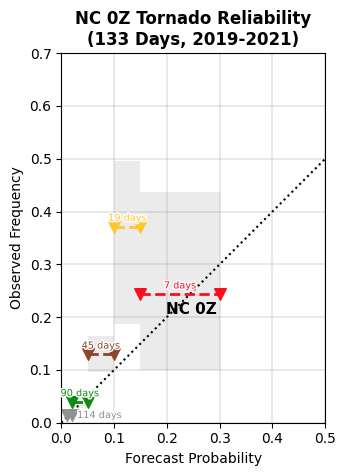

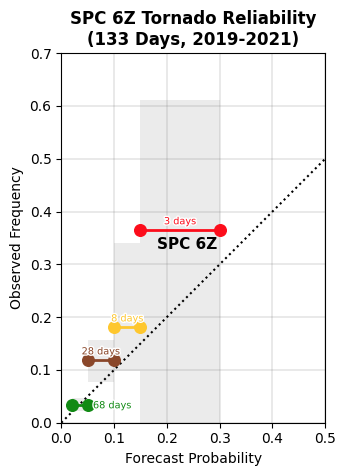

In [42]:
def reliability_plot(csv_path, label, nc_or_spc, nice_event, event, event_colors, xmax, ymax, min_days=2):
    full_df = pd.read_csv(csv_path)

    df = full_df[full_df["event"] == event].copy()
    df = df[df["bin_low"] != 0].copy()
    df = df[df[f"{nc_or_spc}_bin_days"] >= min_days].copy()
    df.index = range(len(df))
    
    fig, ax = plt.subplots()

    ax.set_xlim(0,xmax)
    ax.set_ylim(0,ymax)
    ax.set_xticks(np.arange(0.,xmax + .01,0.1))
    ax.set_yticks(np.arange(0.,ymax + .01,0.1))
    ax.set_xlabel("Forecast Probability")
    ax.set_ylabel("Observed Frequency")
    ax.set_aspect(1)
    ax.grid(color=(.5,.5,.5), linestyle='-', linewidth=0.25)
    ax.set_title(f"{label} {nice_event} Reliability\n({df['days_count'][0]} Days, 2019-2021)", fontdict={"fontweight":"bold"})

    white_outline = [pe.withStroke(linewidth=2, foreground=(1,1,1))]

    ax.plot([0,1], [0,1], linewidth=1.5, linestyle=":", color=(0,0,0))

    last_x, last_y = (0, 0)

    bin_highs = list(df["bin_high_exclusive"])
    if len(df) == 1: # SPC Sig
        bin_highs[0] = 1.0
    
    for i in df.index:
        color = lookup(df["bin_low"][i], event_colors)
        ndays = df[f"{nc_or_spc}_bin_days"][i]
        if i == 0 and len(df) >= 2:
            ax.text(bin_highs[i] + 0.02*xmax, df[f"{nc_or_spc}_observed_rate"][i], f"{ndays} days", fontsize=7, horizontalalignment="left", va="center", c=color, path_effects=white_outline)
        else:
            ax.text(0.5*df["bin_low"][i] + 0.5*min(xmax, bin_highs[i]), df[f"{nc_or_spc}_observed_rate"][i] + 0.01*ymax, f"{ndays} days", fontsize=7, horizontalalignment="center", va="bottom", c=color, path_effects=white_outline)

        linestyle = "--" if nc_or_spc == "nadocast" else "-"
        marker    = "v" if nc_or_spc == "nadocast" else "o"
        ax.plot([df["bin_low"][i], bin_highs[i]], [df[f"{nc_or_spc}_observed_rate"][i], df[f"{nc_or_spc}_observed_rate"][i]], linestyle=linestyle, linewidth=2, color=color)
        ax.scatter([df["bin_low"][i], bin_highs[i]], [df[f"{nc_or_spc}_observed_rate"][i], df[f"{nc_or_spc}_observed_rate"][i]], s=70, marker=marker, color=color, zorder=2)
        last_x, last_y = (bin_highs[i], df[f"{nc_or_spc}_observed_rate"][i])

    if len(df) == 1: # SPC Sig
        ax.text(0.5*df["bin_low"][0] + 0.5*xmax, last_y - 0.02*ymax, label, fontsize=11, horizontalalignment="center", va="top", fontweight="bold")
    else:
        ax.text(last_x - 0.01*xmax, last_y - 0.02*ymax, label, fontsize=11, horizontalalignment="right", va="top", fontweight="bold")

    ax.bar(df["bin_low"], df[f"{nc_or_spc}_observed_rate_0.975_bootstrap"]-df[f"{nc_or_spc}_observed_rate_0.025_bootstrap"], width=bin_highs-df["bin_low"], bottom=df[f"{nc_or_spc}_observed_rate_0.025_bootstrap"], align="edge", zorder=-1, color=(0,0,0,.08))

    plt.show()

reliability_plot("test_reliability_0z_href_only.csv", "NC 0Z", "nadocast", "Tornado", "tornado", tornado_colors, 0.5, 0.7, min_days=2)
reliability_plot("test_reliability_0z_href_only.csv", "SPC 6Z", "spc", "Tornado", "tornado", tornado_colors, 0.5, 0.7, min_days=2)

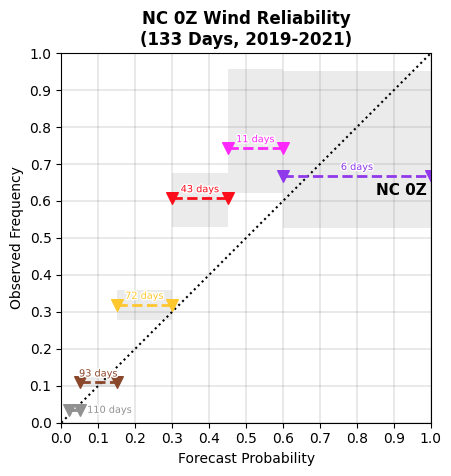

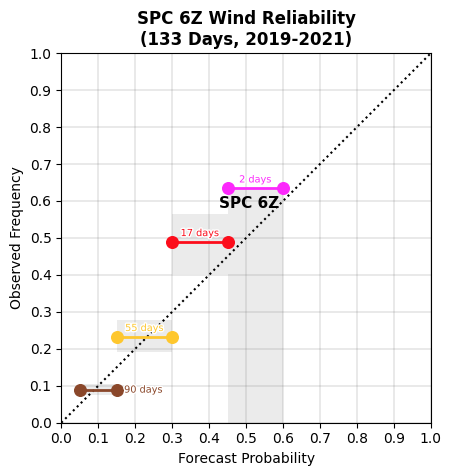

In [43]:
reliability_plot("test_reliability_0z_href_only.csv", "NC 0Z", "nadocast", "Wind", "wind", wind_hail_colors, 1, 1, min_days=2)
reliability_plot("test_reliability_0z_href_only.csv", "SPC 6Z", "spc", "Wind", "wind", wind_hail_colors, 1, 1, min_days=2)

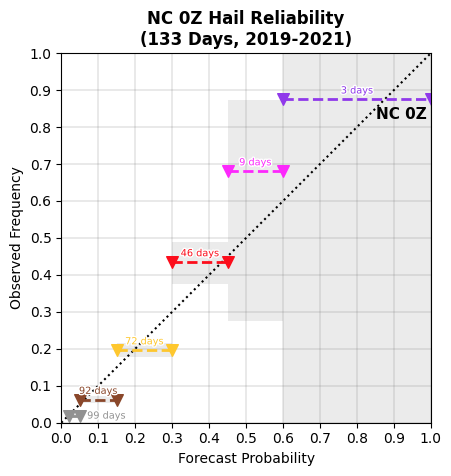

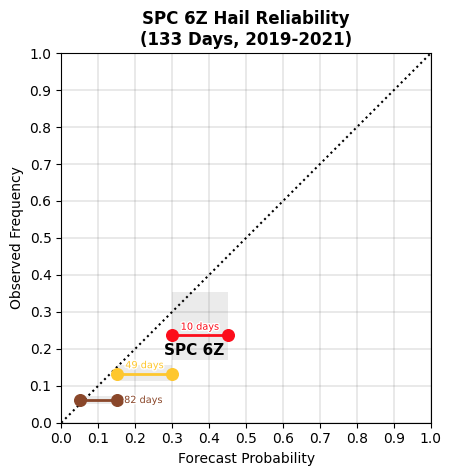

In [44]:
reliability_plot("test_reliability_0z_href_only.csv", "NC 0Z", "nadocast", "Hail", "hail", wind_hail_colors, 1, 1, min_days=2)
reliability_plot("test_reliability_0z_href_only.csv", "SPC 6Z", "spc", "Hail", "hail", wind_hail_colors, 1, 1, min_days=2)

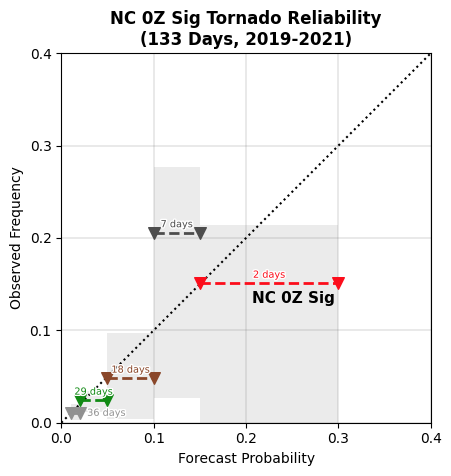

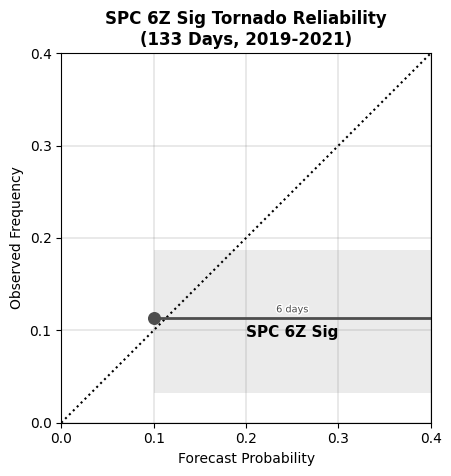

In [55]:
reliability_plot("test_reliability_0z_href_only.csv", "NC 0Z Sig", "nadocast", "Tornado", "sig_tornado_gated_by_tornado", sig_tornado_more_colors, 0.4, 0.4, min_days=2)
reliability_plot("test_reliability_0z_href_only.csv", "SPC 6Z Sig", "spc", "Tornado", "sig_tornado", sig_tornado_more_colors, 0.4, 0.4, min_days=2)

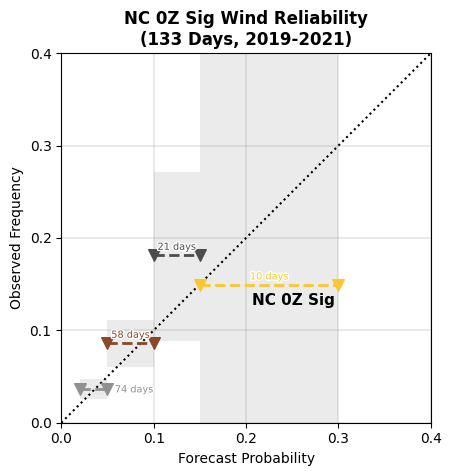

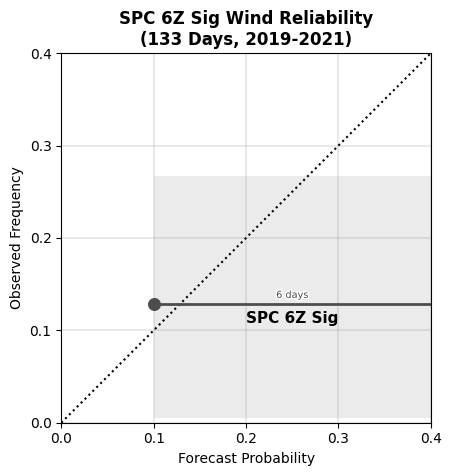

In [54]:
reliability_plot("test_reliability_0z_href_only.csv", "NC 0Z Sig", "nadocast", "Wind", "sig_wind_gated_by_wind", sig_wind_hail_more_colors, 0.4, 0.4, min_days=2)
reliability_plot("test_reliability_0z_href_only.csv", "SPC 6Z Sig", "spc", "Wind", "sig_wind", sig_wind_hail_more_colors, 0.4, 0.4, min_days=2)

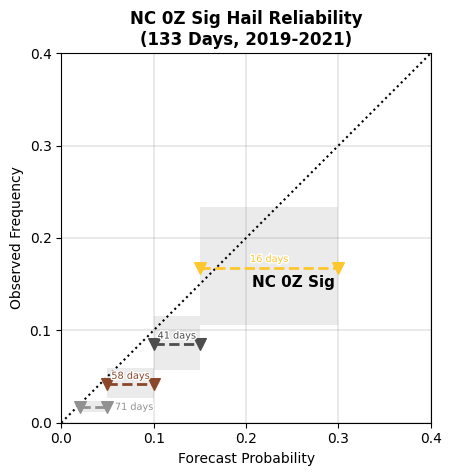

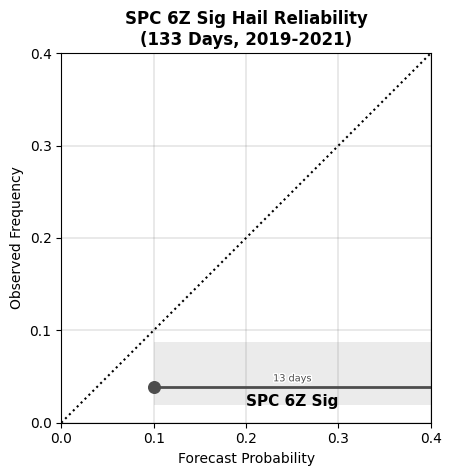

In [53]:
reliability_plot("test_reliability_0z_href_only.csv", "NC 0Z Sig", "nadocast", "Hail", "sig_hail_gated_by_hail", sig_wind_hail_more_colors, 0.4, 0.4, min_days=2)
reliability_plot("test_reliability_0z_href_only.csv", "SPC 6Z Sig", "spc", "Hail", "sig_hail", sig_wind_hail_more_colors, 0.4, 0.4, min_days=2)

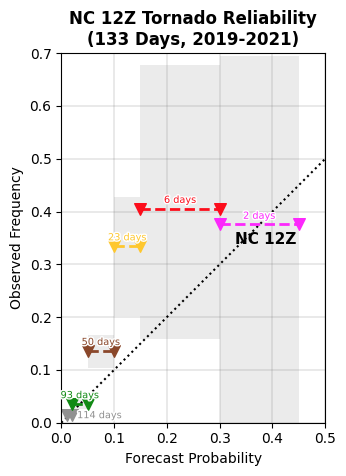

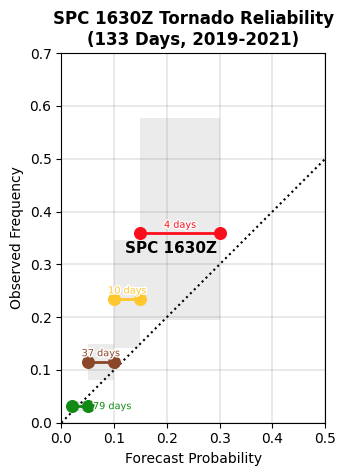

In [48]:
reliability_plot("test_reliability_12z_href_only.csv", "NC 12Z", "nadocast", "Tornado", "tornado", tornado_colors, 0.5, 0.7, min_days=2)
reliability_plot("test_reliability_12z_href_only.csv", "SPC 1630Z", "spc", "Tornado", "tornado", tornado_colors, 0.5, 0.7, min_days=2)

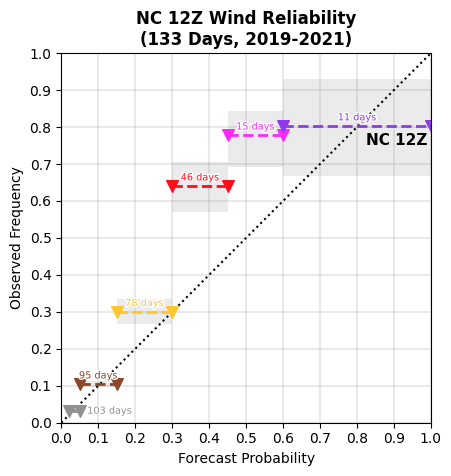

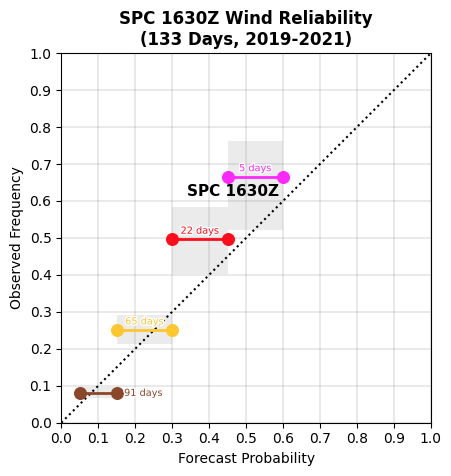

In [49]:
reliability_plot("test_reliability_12z_href_only.csv", "NC 12Z", "nadocast", "Wind", "wind", wind_hail_colors, 1, 1, min_days=2)
reliability_plot("test_reliability_12z_href_only.csv", "SPC 1630Z", "spc", "Wind", "wind", wind_hail_colors, 1, 1, min_days=2)

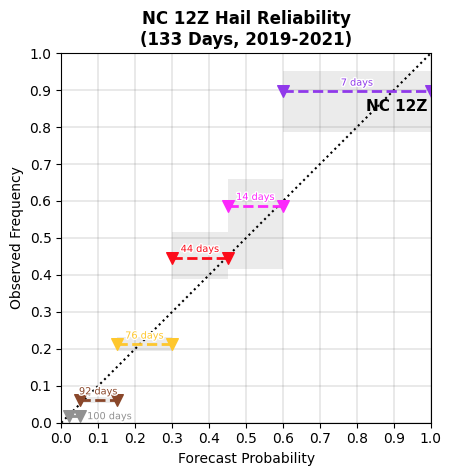

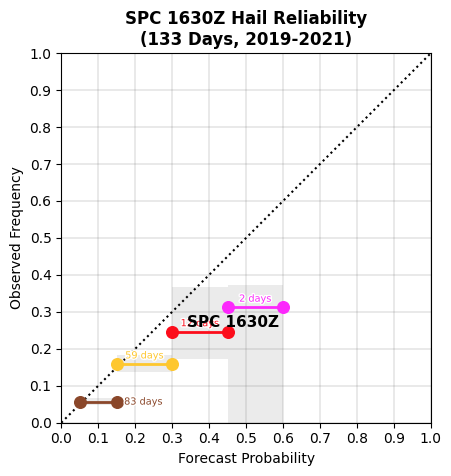

In [59]:
reliability_plot("test_reliability_12z_href_only.csv", "NC 12Z", "nadocast", "Hail", "hail", wind_hail_colors, 1, 1, min_days=2)
reliability_plot("test_reliability_12z_href_only.csv", "SPC 1630Z", "spc", "Hail", "hail", wind_hail_colors, 1, 1, min_days=2)

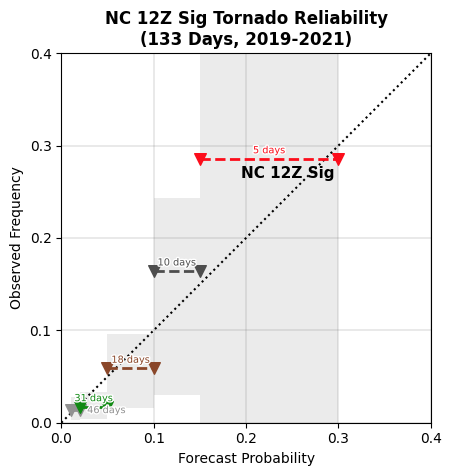

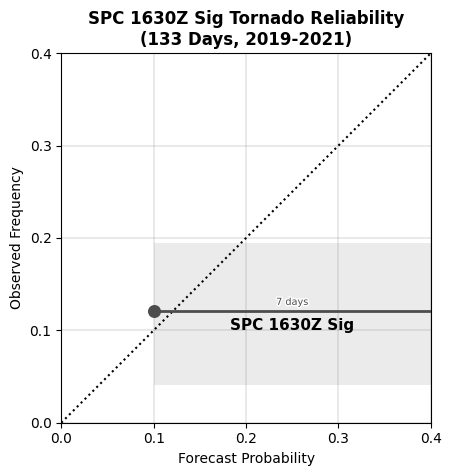

In [60]:
reliability_plot("test_reliability_12z_href_only.csv", "NC 12Z Sig", "nadocast", "Tornado", "sig_tornado_gated_by_tornado", sig_tornado_more_colors, 0.4, 0.4, min_days=2)
reliability_plot("test_reliability_12z_href_only.csv", "SPC 1630Z Sig", "spc", "Tornado", "sig_tornado", sig_tornado_more_colors, 0.4, 0.4, min_days=2)

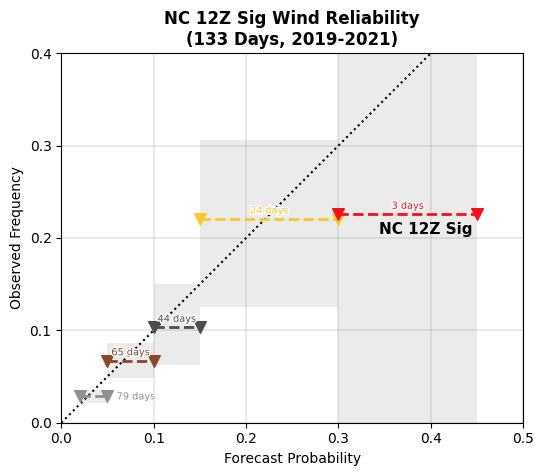

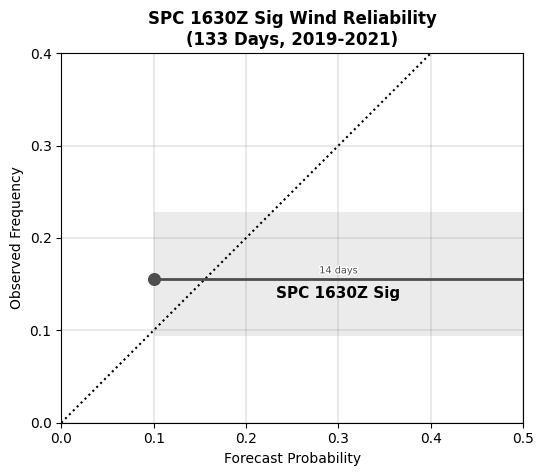

In [63]:
reliability_plot("test_reliability_12z_href_only.csv", "NC 12Z Sig", "nadocast", "Wind", "sig_wind_gated_by_wind", sig_wind_hail_more_colors, 0.5, 0.4, min_days=2)
reliability_plot("test_reliability_12z_href_only.csv", "SPC 1630Z Sig", "spc", "Wind", "sig_wind", sig_wind_hail_more_colors, 0.5, 0.4, min_days=2)

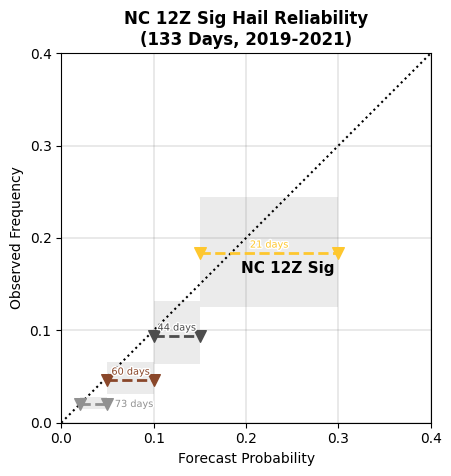

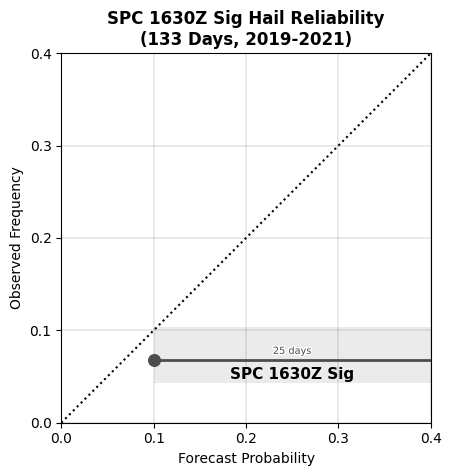

In [65]:
reliability_plot("test_reliability_12z_href_only.csv", "NC 12Z Sig", "nadocast", "Hail", "sig_hail_gated_by_hail", sig_wind_hail_more_colors, 0.4, 0.4, min_days=2)
reliability_plot("test_reliability_12z_href_only.csv", "SPC 1630Z Sig", "spc", "Hail", "sig_hail", sig_wind_hail_more_colors, 0.4, 0.4, min_days=2)

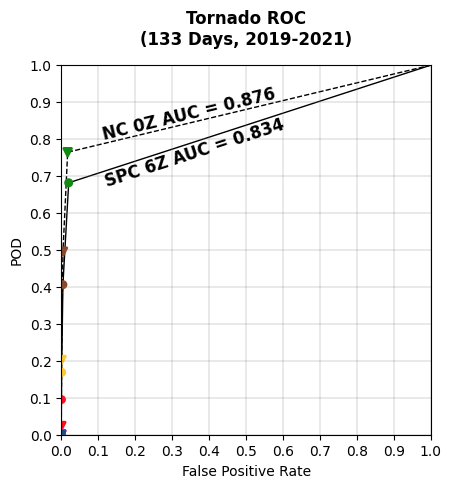

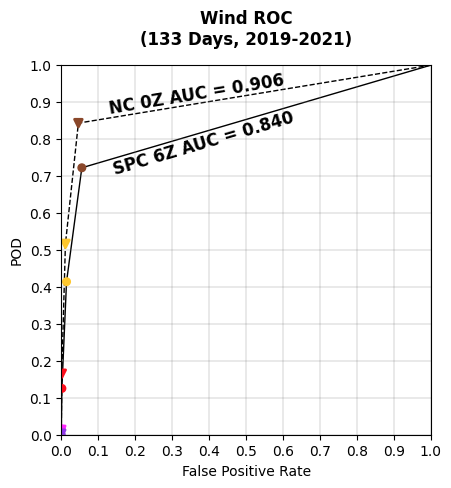

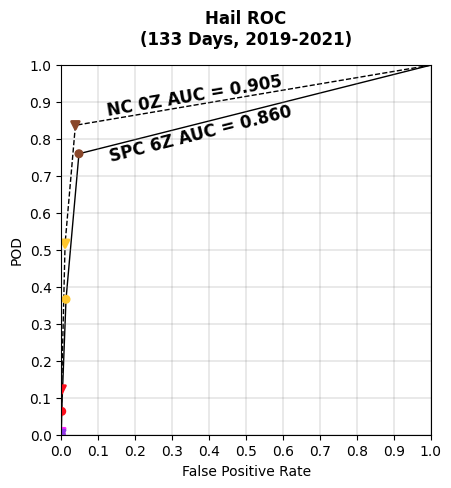

In [21]:
def auc(xs, ys):
    area = 0.0
    for i in range(len(xs) - 1):
        w = abs(xs[i+1] - xs[i])
        lo = min(ys[i], ys[i+1])
        hi = max(ys[i], ys[i+1])
        area += lo*w + 0.5*w*(hi - lo)
    return area

def roc_plot(csv_path, nc_label, spc_label, nice_event, event, sig_event, event_colors, sig_event_colors, xmax, extra_csi_thresholds, nc_sig_label_position=None):
    full_df = pd.read_csv(csv_path)

    df = full_df[full_df["event"] == event].copy()
    if event == "tornado":
        df = df[df["threshold"] >= 0.02].copy()
    else:
        df = df[df["threshold"] >= 0.05].copy()
    df.index = range(len(df))
    df["spc_success_ratio"] = df["spc_success_ratio"].astype(float)
    df["spc_pod"]           = df["spc_pod"].astype(float)
    
    event_colors     = [lookup(threshold, event_colors)     for threshold in df["threshold"]]

    fig, ax = plt.subplots()

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xticks(np.arange(0.,1.01,0.1))
    ax.set_yticks(np.arange(0.,1.01,0.1))
    ax.set_aspect(1)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("POD")
    ax.grid(color=(.5,.5,.5), linestyle='-', linewidth=0.25)


    xmax = ax.get_xlim()[1]
    ymax = ax.get_ylim()[1]

    ax.set_title(f"{nice_event} ROC\n({df['days_count'][0]} Days, 2019-2021)", pad=15, fontdict={"fontweight":"bold"})
    # ax.set_aspect(1)
    
    # SPC
    spc_xs = [1, *df["spc_false_positive_rate"], 0]
    spc_ys = [1, *df["spc_pod"], 0]
    ax.plot(spc_xs, spc_ys, zorder=-1, c=(0,0,0), linewidth=1)
    ax.scatter(df["spc_false_positive_rate"], df["spc_pod"], s=30, marker="o", c=event_colors)

    # NC
    nc_xs = [1, *df["nadocast_false_positive_rate"], 0]
    nc_ys = [1, *df["nadocast_pod"], 0]
    ax.plot(nc_xs, nc_ys, zorder=-1, c=(0,0,0), linewidth=1, linestyle="--")
    ax.scatter("nadocast_false_positive_rate", "nadocast_pod", s=30, marker="v", c=event_colors, edgecolors=event_colors, linewidths=2, data=df)

    # Series labels
    x1, y1 = (spc_xs[1], spc_ys[1])
    x2, y2 = (spc_xs[0], spc_ys[0])
    spc_legend_rot = np.degrees(np.arctan2(y2 - y1, x2 - x1))
    spc_auc = auc(spc_xs, spc_ys)
    ax.text(0.66*spc_xs[1] + 0.34*spc_xs[0], 0.66*spc_ys[1] + 0.34*spc_ys[0] - 0.005*ymax, f"{spc_label} AUC = {spc_auc:.3f}", fontsize=12, horizontalalignment="center", va="top", fontweight="bold", rotation=spc_legend_rot, rotation_mode="anchor")

    x1, y1 = (nc_xs[1], nc_ys[1])
    x2, y2 = (nc_xs[0], nc_ys[0])
    nc_legend_rot = np.degrees(np.arctan2(y2 - y1, x2 - x1))
    nc_auc = auc(nc_xs, nc_ys)
    ax.text(0.66*nc_xs[1] + 0.34*nc_xs[0], 0.66*nc_ys[1] + 0.34*nc_ys[0], f"{nc_label} AUC = {nc_auc:.3f}",  fontsize=12, horizontalalignment="center", va="bottom", fontweight="bold", rotation=nc_legend_rot, rotation_mode="anchor")


    plt.show()


roc_plot("stats_0z_href_only.csv", "NC 0Z", "SPC 6Z", "Tornado", "tornado", "sig_tornado_gated_by_tornado", tornado_colors, sig_tornado_more_colors, 0.4, [0.05, 0.15, 0.25, 0.35])
roc_plot("stats_0z_href_only.csv", "NC 0Z", "SPC 6Z", "Wind", "wind", "sig_wind_gated_by_wind", wind_hail_colors, sig_wind_hail_more_colors, 0.8, [0.05])
roc_plot("stats_0z_href_only.csv", "NC 0Z", "SPC 6Z", "Hail", "hail", "sig_hail_gated_by_hail", wind_hail_colors, sig_wind_hail_more_colors, 1, [0.05])

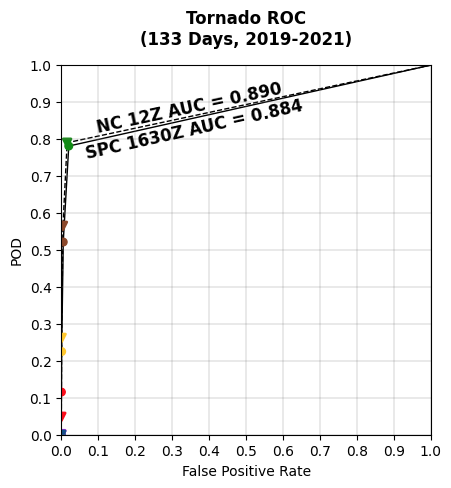

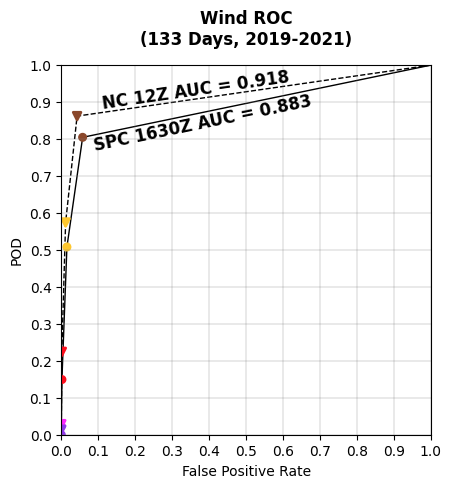

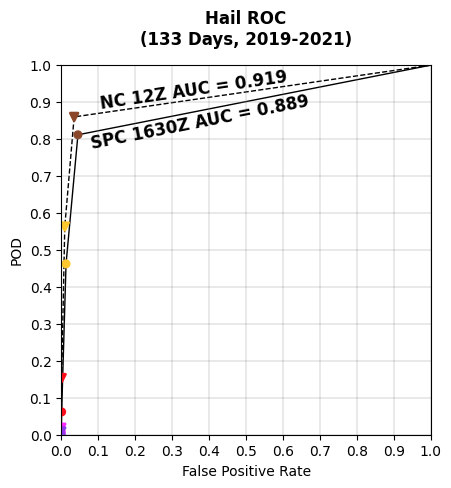

In [22]:
roc_plot("stats_12z_href_only.csv", "NC 12Z", "SPC 1630Z", "Tornado", "tornado", "sig_tornado_gated_by_tornado", tornado_colors, sig_tornado_more_colors, 0.4, [0.05, 0.15, 0.25, 0.35])
roc_plot("stats_12z_href_only.csv", "NC 12Z", "SPC 1630Z", "Wind", "wind", "sig_wind_gated_by_wind", wind_hail_colors, sig_wind_hail_more_colors, 0.8, [0.05])
roc_plot("stats_12z_href_only.csv", "NC 12Z", "SPC 1630Z", "Hail", "hail", "sig_hail_gated_by_hail", wind_hail_colors, sig_wind_hail_more_colors, 1, [0.05])